In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
    
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, LSTM
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential, load_model


## Making sure we can read in our images

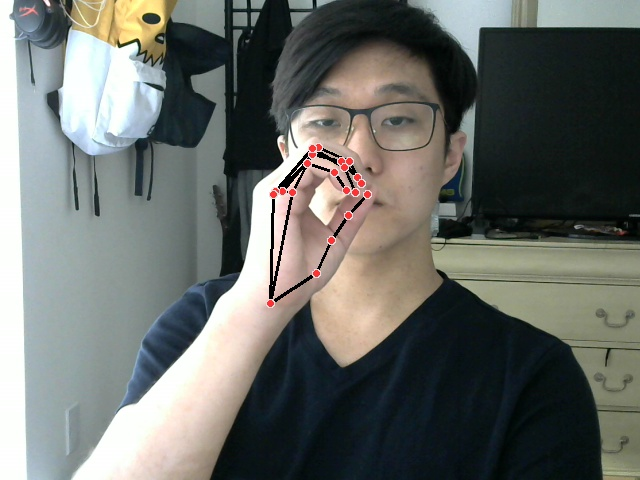

In [4]:
img_test = load_img('./imgs/train/screenshot/screenshot.a1021b30-401f-11ec-a31e-68545a69f685.jpg')
img_test

In [5]:
# Checking shape as well as first rows of pixel
img_test_2 = cv2.imread('./imgs/train/screenshot/screenshot.a1021b30-401f-11ec-a31e-68545a69f685.jpg')
print(img_test_2.shape)
cv2.imread('./imgs/train/screenshot/screenshot.a1021b30-401f-11ec-a31e-68545a69f685.jpg')[0][:10]

(480, 640, 3)


array([[253, 255, 255],
       [253, 255, 255],
       [253, 255, 255],
       [253, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [254, 255, 253]], dtype=uint8)

## Setting up the images in our folders 

#### Rescaling our Data

In [6]:
train = ImageDataGenerator(rescale=1/255)
test = ImageDataGenerator(rescale=1/255)

#### Make get target names from the folders they were saved in as, and make sure pictures are all the same size

In [7]:
train_set = train.flow_from_directory('./imgs/train/',
                                    target_size=(480,640), # just in case any of the pictures changed sizes for some reason
                                    class_mode='categorical',
                                    batch_size=16)

test_set = test.flow_from_directory('./imgs/test/',
                                   target_size=(480,640),
                                   class_mode='categorical',
                                   batch_size= 16)

Found 67 images belonging to 6 classes.
Found 18 images belonging to 6 classes.


In [8]:
# Check the class indicies the imageDataGenerator just made
train_set.class_indices

{'forward': 0,
 'play_pause': 1,
 'rewind': 2,
 'screenshot': 3,
 'volume_down': 4,
 'volume_up': 5}

In [148]:
# See how the classes are
train_set.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5])

this doesnt seem to work to try to split it up for x_train, y_train type thing
```python
# getting everything except for the label
X_train_set = [train_set[i][:-1] for i in range(len(train_set))]
# getting the labels for the training set
y_train_set = [train_set[i][-1] for i in range(len(train_set))]


# getting everything except for the label
X_test_set = [train_set[i][:-1] for i in range(len(test_set))]
# getting the labels
y_test_set = [train_set[i][-1] for i in range(len(test_set))]
```

## Preparing the CNN model
1. cnn_1.h5
    1. batch_size when reading in was either 2 or 4
1. cnn_2.h5
    1. batch_size now 16

In [149]:
input_shape = train_set.image_shape
input_shape

(480, 640, 3)

In [150]:
# Getting how many samples we have to work with for the layer 
train_set.samples

67

In [151]:
cnn_1 = Sequential()

# adding the 1st convolutional layer
cnn_1.add(Conv2D(filters = 32,
                 kernel_size = (3,3),
                 activation = 'relu',
                 input_shape = input_shape))
# adding first pooling
cnn_1.add(MaxPooling2D(pool_size = (2,2)))

# adding a 2nd convolutional layer
cnn_1.add(Conv2D(filters = 64,
                 kernel_size = (3,3),
                 activation = 'relu'))
# 2nd pooling
cnn_1.add(MaxPooling2D(pool_size =(2,2)))

# flatten it all
cnn_1.add(Flatten())

# add the Dense layers
cnn_1.add(Dense(128, activation = 'relu'))
cnn_1.add(Dense(64, activation = 'relu'))
# final layer with 6 classes so 6 nodes 
cnn_1.add(Dense(6, activation = 'softmax'))

In [152]:
cnn_1.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics=['acc'])

In [153]:
history = cnn_1.fit(train_set,
                    epochs=150,
                    callbacks=[
                        ModelCheckpoint('models/cnn_2.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, verbose=1, mode='auto') ],
                    validation_data= test_set)

Epoch 1/150
5/5 [==============================] - 16s 3s/step - loss: 41.4200 - acc: 0.2239 - val_loss: 11.5923 - val_acc: 0.1667

Epoch 00001: val_loss improved from inf to 11.59229, saving model to models\cnn_2.h5
Epoch 2/150
5/5 [==============================] - 14s 3s/step - loss: 6.6942 - acc: 0.2985 - val_loss: 1.7834 - val_acc: 0.5000

Epoch 00002: val_loss improved from 11.59229 to 1.78337, saving model to models\cnn_2.h5
Epoch 3/150
5/5 [==============================] - 15s 3s/step - loss: 1.6387 - acc: 0.4478 - val_loss: 1.6931 - val_acc: 0.3889

Epoch 00003: val_loss improved from 1.78337 to 1.69308, saving model to models\cnn_2.h5
Epoch 4/150
5/5 [==============================] - 14s 3s/step - loss: 1.3207 - acc: 0.7612 - val_loss: 1.3589 - val_acc: 0.5000

Epoch 00004: val_loss improved from 1.69308 to 1.35893, saving model to models\cnn_2.h5
Epoch 5/150
5/5 [==============================] - 14s 3s/step - loss: 0.6000 - acc: 0.8657 - val_loss: 1.0232 - val_acc: 0.5556

5/5 [==============================] - 15s 3s/step - loss: 7.4016e-07 - acc: 1.0000 - val_loss: 0.0681 - val_acc: 1.0000

Epoch 00043: val_loss did not improve from 0.05689
Epoch 44/150
5/5 [==============================] - 15s 3s/step - loss: 7.3305e-07 - acc: 1.0000 - val_loss: 0.0679 - val_acc: 1.0000

Epoch 00044: val_loss did not improve from 0.05689
Epoch 45/150
5/5 [==============================] - 15s 3s/step - loss: 7.2771e-07 - acc: 1.0000 - val_loss: 0.0679 - val_acc: 1.0000

Epoch 00045: val_loss did not improve from 0.05689
Epoch 46/150
5/5 [==============================] - 15s 3s/step - loss: 7.2237e-07 - acc: 1.0000 - val_loss: 0.0676 - val_acc: 1.0000

Epoch 00046: val_loss did not improve from 0.05689
Epoch 47/150
5/5 [==============================] - 15s 3s/step - loss: 7.1525e-07 - acc: 1.0000 - val_loss: 0.0675 - val_acc: 1.0000

Epoch 00047: val_loss did not improve from 0.05689
Epoch 48/150
5/5 [==============================] - 15s 3s/step - loss: 7.0992e-07 


Epoch 00128: val_loss did not improve from 0.05689
Epoch 129/150
5/5 [==============================] - 15s 4s/step - loss: 6.0138e-07 - acc: 1.0000 - val_loss: 0.0678 - val_acc: 1.0000

Epoch 00129: val_loss did not improve from 0.05689
Epoch 130/150
5/5 [==============================] - 16s 4s/step - loss: 6.0138e-07 - acc: 1.0000 - val_loss: 0.0678 - val_acc: 1.0000

Epoch 00130: val_loss did not improve from 0.05689
Epoch 131/150
5/5 [==============================] - 15s 3s/step - loss: 6.0138e-07 - acc: 1.0000 - val_loss: 0.0678 - val_acc: 1.0000

Epoch 00131: val_loss did not improve from 0.05689
Epoch 132/150
5/5 [==============================] - 15s 3s/step - loss: 6.0138e-07 - acc: 1.0000 - val_loss: 0.0678 - val_acc: 1.0000

Epoch 00132: val_loss did not improve from 0.05689

Epoch 00132: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 133/150
5/5 [==============================] - 16s 3s/step - loss: 6.0138e-07 - acc: 1.0000 - val_loss: 0.0678 - 

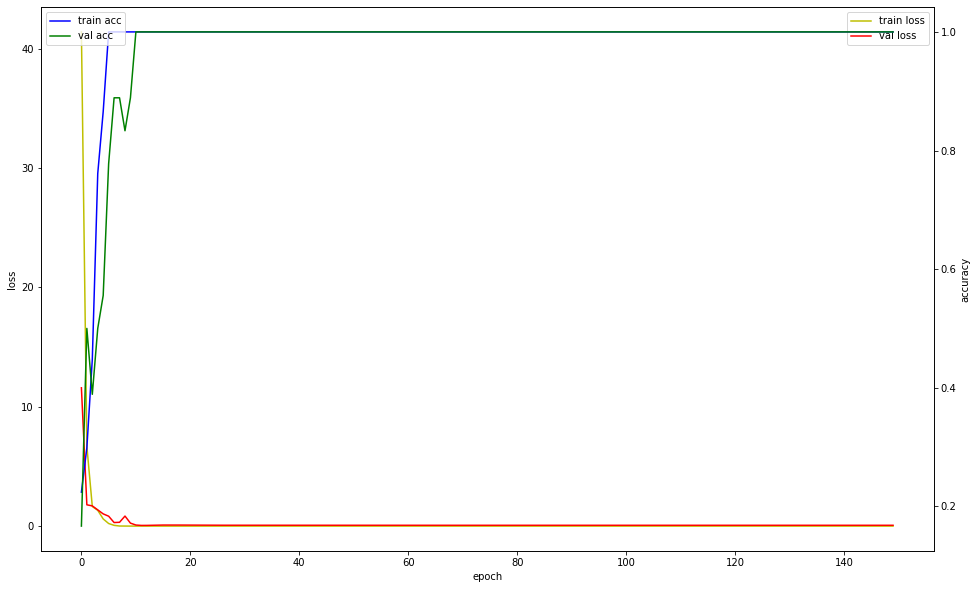

In [154]:
fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='best')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [34]:
# loading in the model so i don't have to rerun the training thing
cnn_2 = load_model('./models/cnn_2.h5')

In [74]:
preds = cnn_2.predict(test_set)

In [46]:
holder = {}
for i, v in enumerate(test_set.classes):
    holder[i] = v

In [73]:
[test_set.classes[index] for index in test_set.index_array]

[1, 5, 4, 5, 1, 3, 4, 0, 4, 2, 0, 2, 3, 0, 5, 1, 3, 2]

In [75]:
# actually getting the results back from prediction
np.argmax(preds, axis = 1)

array([1, 5, 4, 5, 1, 3, 4, 0, 4, 2, 0, 2, 3, 0, 5, 1, 3, 2], dtype=int64)

In [78]:
# what the heck does squeeze do again?
np.argmax(preds, axis = 1)

array([1, 5, 4, 5, 1, 3, 4, 0, 4, 2, 0, 2, 3, 0, 5, 1, 3, 2], dtype=int64)

In [59]:
list(np.argmax(cnn_2.predict(test_set), axis = 1))

[5, 4, 5, 3, 2, 2, 4, 0, 4, 2, 3, 1, 1, 0, 5, 3, 1, 0]

## Cnn Model 2

#### will focus on getting a better model once i know i can use this type of modeling and pictures to get something going

```python
cnn_2 = Sequential()

# adding the 1st convolutional layer
cnn_2.add(Conv2D(filters = 16,
                 kernel_size = (3,3),
                 activation = 'relu',
                 input_shape = input_shape))
# adding first pooling
cnn_2.add(MaxPooling2D(pool_size = (2,2)))

# adding a 2nd convolutional layer
cnn_2.add(Conv2D(filters = 32,
                 kernel_size = (3,3),
                 activation = 'relu'))
# 2nd pooling
cnn_2.add(MaxPooling2D(pool_size =(2,2)))

# flatten it all
cnn_2.add(Flatten())

# add the Dense layers
cnn_2.add(LSTM(128, activation = 'relu'))
cnn_2.add(Dense(64, activation = 'relu'))
# final layer with 6 classes so 6 nodes 
cnn_2.add(Dense(6, activation = 'softmax'))

cnn_2.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics=['acc'])
```